<a href="https://colab.research.google.com/github/FabianaFerrente/ibis_pipeline/blob/master/deconv_ibis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Mount Google Drive
drive.mount('/content/drive')


shared_folder_path = '/content/drive/MyDrive/dest_IBIS/'

Mounted at /content/drive


In [2]:
!pip install torchmfbd



  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.2/180.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 16.3 MB/s eta 0:00:00
  Created wheel for dict-hash: filename=dict_hash-1.3.7-py3-none-any.whl size=11018 sha256=c8cfd277895f4d3648d4ce05080cfc4260b913120289ccd5372d518ed9de9ae5
  Stored in directory: /root/.cache/pip/wheels/91/d9/9e/f279036ae3e5cd16d74db80dce0c4b0480b7cc47f3b52bffc7
  Created wheel for deflate_dict: filename=deflate_dict-1.2.2-py3-none-any.whl size=7955 sha256=88ed9a1b50472607451a2cb57c84b3ea2aa46b02a719cc38984a08ee1398ec8a
  Stored in directory: /root/.cache/pip/wheels/bf/14/51/d2c7dd64717047824a668e07ac84d357812fe09050e98f1e92
Successfully built dict-hash deflate_dict


In [5]:
import numpy as np
import torch.nn.functional as F
import torch
from einops import rearrange

class Patchify4D(object):
    def __init__(self):
        super().__init__()

    def patchify(self, x, patch_size=64, stride_size=64, flatten_sequences=True, return_coordinates=False):
        """
        Splits the input tensor into patches.
        Args:
            x (torch.Tensor): Input tensor of shape (n_scans, n_frames, nx, ny).
            patch_size (int, optional): Size of each patch. Default is 64.
            stride_size (int, optional): Stride size for patch extraction. Default is 64.
            flatten_sequences (bool, optional): If True, the output tensor will have shape (n_scans * n_frames, patch_size, patch_size). Default is True.
            return_coordinates (bool, optional): If True, the function will return the coordinates of the patches. Default is False.
        Returns:
            torch.Tensor: Tensor containing the patches with shape (n_scans, L, n_frames, patch_size, patch_size), where L is the number of patches extracted.
        """

        self.n_scans, self.n_frames, self.nx, self.ny = x.shape

        self.output_size = (self.nx, self.ny)
        self.flatten_sequences = flatten_sequences

        # padding, kernel size, stride, dilation and size of the input
        self.P = 0.0
        self.K = patch_size
        self.S = stride_size
        self.X = self.nx
        self.Y = self.ny
        self.D = 1.0

        # Compute the size of blocks that will be extracted using unfold
        self.Lx = np.floor((self.X + 2*self.P - self.D*(self.K-1) - 1) / self.S + 1).astype(int)
        self.Ly = np.floor((self.Y + 2*self.P - self.D*(self.K-1) - 1) / self.S + 1).astype(int)

        # This masks is used to weight the patches when unpatchifying to allow for overlapping patches
        self.mask = torch.ones_like(x).to(x.device)

        x = F.unfold(x, kernel_size=self.K, stride=self.S)
        self.mask = F.unfold(self.mask, kernel_size=self.K, stride=self.S)

        # x -> B (c*p*p) L
        self.n_patches = x.shape[-1]

        # Reshaping into the shape we want
        if self.flatten_sequences:
            a = rearrange(x, '(n) (f x y) L -> (n L) f x y', x=self.K, y=self.K, n=self.n_scans)
            self.mask = rearrange(self.mask, '(n) (f x y) L -> (n L) f x y', x=self.K, y=self.K, n=self.n_scans)
        else:
            a = rearrange(x, '(n) (f x y) L -> n L f x y', x=self.K, y=self.K, n=self.n_scans)
            self.mask = rearrange(self.mask, '(n) (f x y) L -> n L f x y', x=self.K, y=self.K, n=self.n_scans)

        if return_coordinates:
            x = 1.0 * torch.arange(self.nx) - self.nx // 2
            y = 1.0 * torch.arange(self.ny) - self.ny // 2
            X, Y = torch.meshgrid(x, y, indexing='ij')
            coordX = F.unfold(X[None, None, :, :], kernel_size=self.K, stride=self.S)
            coordY = F.unfold(Y[None, None, :, :], kernel_size=self.K, stride=self.S)

            if self.flatten_sequences:
                coordX = rearrange(coordX, '(n) (f x y) L -> (n L) f x y', x=self.K, y=self.K, n=self.n_scans)
                coordY = rearrange(coordY, '(n) (f x y) L -> (n L) f x y', x=self.K, y=self.K, n=self.n_scans)

            patchX = torch.mean(coordX, dim=(-1, -2))
            patchY = torch.mean(coordY, dim=(-1, -2))

            XY = torch.cat([patchX, patchY], dim=-1)

            return a, XY

        else:

            return a

    def unpatchify(self, x, apodization=0, weight_type=None, weight_params=None):
        """
        Reconstructs the original image from patches.
        Args:
            x (torch.Tensor): The input tensor containing image patches with shape
                              (n, L, f, x, y), where:
                              - n: number of scans
                              - L: number of patches
                              - o: number of objects
                              - f: number of frames (optional)
                              - x, y: patch dimensions
            apodization (int, optional): Number of pixels to apodize at the edges of the image. Default is 0.
        Returns:
            torch.Tensor: The reconstructed image tensor with shape
                          (n, o, f, x, y), where:
                          - n: number of scans
                          - o: number of objects
                          - f: number of features (optional)
                          - x, y: image dimensions
        """

        xndim = x.ndim
        if xndim == 3:
            if self.flatten_sequences:
                x2 = x.clone().unsqueeze(1)
            else:
                x2 = x.clone().unsqueeze(2)
            mask = self.mask[:, 0:1, :, :].clone()
        else:
            x2 = x.clone()
            mask = self.mask.clone()

        mask = mask.to(x.device)

        if apodization > 0:
            x2 = x2[:, :, apodization:-apodization, apodization:-apodization]
            mask = mask[:, :, apodization:-apodization, apodization:-apodization]

        # Weight
        if weight_type is None:
            npix = x2.shape[-2]
            self.weight = torch.ones((npix, npix)).to(x.device)

        if weight_type == 'gaussian':
            npix = x2.shape[-2]
            xx = torch.linspace(-1, 1, npix, device=x.device)
            yy = torch.linspace(-1, 1, npix, device=x.device)
            X, Y = torch.meshgrid(xx, yy, indexing='ij')
            R = torch.sqrt(X**2 + Y**2)
            self.weight = torch.exp(-R**2 / weight_params)

        if weight_type == 'cosine':
            npix = x2.shape[-2]
            npix_apod = min(weight_params, npix//2)

            # Add a small value to avoid division by zero
            win = np.hanning(2*npix_apod)
            winOut = np.ones(npix)
            winOut[0:npix_apod] = win[0:npix_apod]
            winOut[-npix_apod:] = win[-npix_apod:]
            weight = np.outer(winOut, winOut)
            self.weight = torch.tensor(weight.astype('float32'), device=x.device)

        # Reduce the size of the patch to account for the apodization
        K = self.K - 2*apodization

        # Compute the new size of the image
        new_size_x = int((self.Lx - 1) * self.S + 1 - 2*self.P + self.D*(K-1))
        new_size_y = int((self.Ly - 1) * self.S + 1 - 2*self.P + self.D*(K-1))

        output_size = (new_size_x, new_size_y)

        # Apply the weighting to the patches
        x2 *= self.weight[None, None, :, :]
        mask *= self.weight[None, None, :, :]

        if self.flatten_sequences:
            x2 = rearrange(x2, '(n L) f x y -> (n) (f x y) L', n=self.n_scans, L=self.n_patches)
            mask = rearrange(mask, '(n L) f x y -> (n) (f x y) L', n=self.n_scans, L=self.n_patches)
        else:
            x2 = rearrange(x2, 'n L f x y -> (n) (f x y) L')
            mask = rearrange(mask, 'n L f x y -> (n) (f x y) L')

        x2 = F.fold(x2, output_size=output_size, kernel_size=K, stride=self.S)
        mask = F.fold(mask, output_size=output_size, kernel_size=K, stride=self.S)

        x2 = rearrange(x2, '(n) f x y -> n f x y', n=self.n_scans)
        mask = rearrange(mask, '(n) f x y -> n f x y', n=self.n_scans)

        final = x2 / (mask + 1e-10)

        if xndim == 3:
            final = final.squeeze(1)

        return final

if __name__ == '__main__':
    n_scans = 1
    n_frames = 12
    n_x = 80
    n_y = 80

    frames = torch.randn(n_scans, n_frames, n_x, n_y)

    p = Patchify4D()

    patches = p.patchify(frames, patch_size=20, stride_size=10)

    out = p.unpatchify(patches, apodization=3)

2025-11-15 10:16:47,970 - deconvolution  - Using configuration file /content/drive/MyDrive/dest_IBIS/deconv.yaml
INFO:deconvolution :Using configuration file /content/drive/MyDrive/dest_IBIS/deconv.yaml
CRITICAL:nvitop.api.libnvml:FATAL ERROR: NVIDIA Management Library (NVML) not found.
HINT: The NVIDIA Management Library ships with the NVIDIA display driver (available at
      https://www.nvidia.com/Download/index.aspx), or can be downloaded as part of the
      NVIDIA CUDA Toolkit (available at https://developer.nvidia.com/cuda-downloads).
      The lists of OS platforms and NVIDIA-GPUs supported by the NVML library can be
      found in the NVML API Reference at https://docs.nvidia.com/deploy/nvml-api.
2025-11-15 10:16:47,998 - deconvolution  - No GPU is available. Computing in cpu
INFO:deconvolution :No GPU is available. Computing in cpu
2025-11-15 10:16:48,002 - deconvolution  - Using apodization mask with a border of 6 pixels
INFO:deconvolution :Using apodization mask with a bord

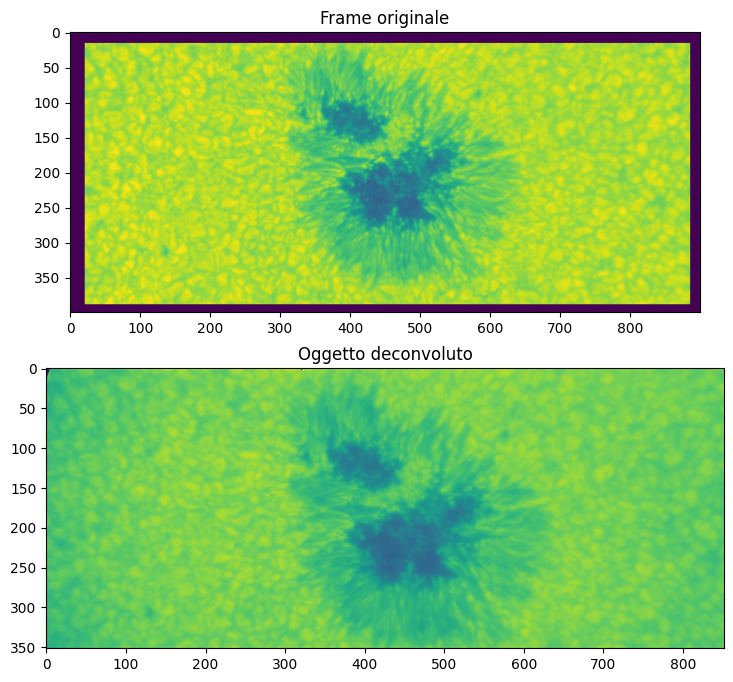

In [10]:
from astropy.io import fits
import torch
import torchmfbd
import matplotlib.pyplot as pl

# Assicurati che Patchify4D sia già importata
p = Patchify4D()

# --- LOAD ---
fits_file_path1 = '/content/drive/MyDrive/dest_IBIS/ref_WL.fits'
fits_file_path2 = '/content/drive/MyDrive/dest_IBIS/8542_20150518_163819_BB_SO_s000.fits'

with fits.open(fits_file_path1) as hdul:
    wl = hdul[0].data.astype(float)
with fits.open(fits_file_path2) as hdul:
    bb_cube = hdul[0].data.astype(float)

# --- CUT ROI ---
ymin, ymax = 300, 700
xmin, xmax = 50, 950
wl_cut = wl[ymin:ymax, xmin:xmax]
bb_cut = bb_cube[:, ymin:ymax, xmin:xmax]

# --- Aggiungi dimensione n_scans=1 per Patchify4D ---
frames = torch.tensor(bb_cut[None, :, :, :], dtype=torch.float32)  # shape (n_scans=1, n_frames, ny, nx)

# --- Patchify ---
frames_patches = p.patchify(
    frames,
    patch_size=64,
    stride_size=50,
    flatten_sequences=True
)

# --- Preparazione deconvoluzione ---
deconv = torchmfbd.Deconvolution(shared_folder_path+'deconv.yaml')
deconv.add_frames(
    frames_patches,
    id_object=0,
    id_diversity=0,
    diversity=0.0
)

# --- Deconvoluzione ---
deconv.deconvolve(
    infer_object=False,
    optimizer='adam',
    simultaneous_sequences=25,
    n_iterations=20
)

# --- Ricostruzione oggetto deconvoluto ---
obj = p.unpatchify(deconv.obj[0], apodization=6)
frames_back = p.unpatchify(frames_patches, apodization=0)

npix = obj[0, :, :].shape[0]

# --- Plot ---
fig, ax = pl.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax[0].imshow(wl_cut)
ax[0].set_title('Frame originale')
ax[1].imshow(obj[0, :, :])
ax[1].set_title('Oggetto deconvoluto')

# --- Salva FITS ---
deconv.write('output.fits')


In [4]:
frames.shape

(25, 1, 400, 900)